In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import scipy.special as fun
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"


days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./(obs_per_day * linspace))
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5


def true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda - true_rho * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], state_ls[:, 1], np.log(states[:, 2])


Tt, It, true_x = true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day)
It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma[::1000]) * np.exp(true_x))


class Bessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp, nu):
        ctx._nu = nu
        ctx.save_for_backward(inp)
        mat = fun.kv(nu, inp.detach().numpy())
        return (torch.from_numpy(np.array(mat)))

    @staticmethod
    def backward(ctx, grad_out):
        inp, = ctx.saved_tensors
        nu = ctx._nu
        grad_in = grad_out.numpy() * np.array(fun.kvp(nu, inp.detach().numpy()))
        return (torch.from_numpy(grad_in), None)


class generalMatern(object):

    # has_lengthscale = True

    def __init__(self, nu, lengthscale, **kwargs):
        # super(Matern,self).__init__(**kwargs)
        self.nu = nu
        self.log_lengthscale = torch.tensor(np.log(lengthscale))
        self.log_lengthscale.requires_grad_(True)

    def _set_lengthscale(self, lengthscale):
        self.log_lengthscale = torch.tensor(np.log(lengthscale))

    def lengthscale(self):
        return (torch.exp(self.log_lengthscale).item())

    def forward(self, x1, x2=None, **params):
        lengthscale = torch.exp(self.log_lengthscale)
        x1 = x1.squeeze()
        if x2 is None: x2 = x1
        r_ = (x1.reshape(-1, 1) - x2.reshape(1, -1)).abs()
        r_ = np.sqrt(2. * self.nu) * r_ / lengthscale
        # handle limit at 0, allows more efficient backprop
        r_ = torch.clamp(r_, min=1e-15)
        C_ = np.power(2, 1 - self.nu) * np.exp(-fun.loggamma(self.nu)) * torch.pow(r_, self.nu)
        mat = Bessel.apply(r_, self.nu)
        C_ = C_ * mat
        return (C_)

    def C(self, x1, x2=None):
        return (self.forward(x1, x2).detach())

    


ker = generalMatern(2.01, 5.5)
cov_matrix = ker.C(torch.tensor(np.arange(0, 100, 1)))

days = 100
obs_per_day = 1
all_a = np.zeros((100, days * obs_per_day))              
all_xinit = np.zeros(100)
for i in range(100):
    file = np.load('G:/0114/HIV-res/HIV-a-mean-' + str(i) + '.npy')
    all_a[i] = file
    all_xinit[i] = np.load('G:/0114/HIV-res/HIV-xinit-mean-' + str(i) + '.npy')
    
    
a_RMSE = np.zeros(100)
for i in range(100):
    a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - all_a[i])))

print(np.mean(a_RMSE), np.std(a_RMSE))
cov_matrix

359.0416733413551 127.89634115013716


tensor([[1.0000e+00, 9.6914e-01, 8.9024e-01,  ..., 6.2573e-14, 4.4113e-14,
         3.1094e-14],
        [9.6914e-01, 1.0000e+00, 9.6914e-01,  ..., 8.8746e-14, 6.2573e-14,
         4.4113e-14],
        [8.9024e-01, 9.6914e-01, 1.0000e+00,  ..., 1.2585e-13, 8.8746e-14,
         6.2573e-14],
        ...,
        [6.2573e-14, 8.8746e-14, 1.2585e-13,  ..., 1.0000e+00, 9.6914e-01,
         8.9024e-01],
        [4.4113e-14, 6.2573e-14, 8.8746e-14,  ..., 9.6914e-01, 1.0000e+00,
         9.6914e-01],
        [3.1094e-14, 4.4113e-14, 6.2573e-14,  ..., 8.9024e-01, 9.6914e-01,
         1.0000e+00]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


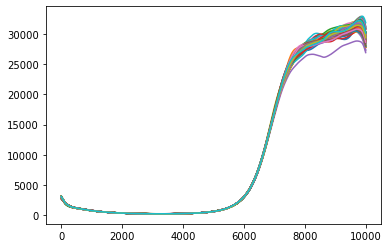

In [30]:
def GPinterp(x, a, ker, inv_cov, days=100, obs_per_day=1):
    x_obs = np.arange(0, days, 1 / obs_per_day)
    return a.T.dot(inv_cov).dot(ker.C(torch.tensor(np.abs(x_obs - x)), x2=torch.tensor(np.zeros(100)))[:, 0])

# a_inv_cov = np.linalg.inv(cov_matrix)
# GPinterp(50, all_a[0], ker, a_inv_cov)

def recover_data(a, state0, linspace=100, days=100, obs_per_day=1, discretization=1, mode = 'Gaussian'):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    x_initial = np.linspace(0, 1000, days)
    x_interp = np.linspace(0, 1000, days * linspace)
    if mode == 'Linear': 
        a_interp = np.interp(x_interp, x_initial, a)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        global ker, cov_matrix
        n_points = days * discretization * obs_per_day
        d_matrix = np.zeros((n_points, n_points))
        a_interp = np.zeros(10000)
        a_inv_cov = np.linalg.inv(cov_matrix)
        for i in range(10000):
            a_interp[i] = GPinterp(i / (obs_per_day * linspace), a, ker, a_inv_cov)
            
        plt.plot(a_interp)
    else:
        raise ValueError
        
    for i in range(1, linspace * days):
        index = i - 1
        state_ls[i] = state_ls[i - 1] + step_size * (a_interp[i -1] * np.exp(-state_ls[i - 1]) - 3.5)
    return state_ls[::linspace]


all_reconstructed_x = np.zeros((100, 100))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_a[i], all_xinit[i])

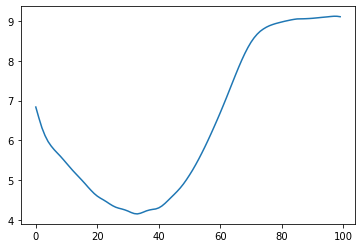

In [29]:
plt.plot( all_reconstructed_x[0])

In [31]:
x_RMSE = np.zeros(100)
for i in range(100):
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))
    
    
print(np.mean(x_RMSE), np.std(x_RMSE))

0.039525999778245925 0.0036533112161605368


In [35]:
TVMAGI_a_ls = np.zeros((100, 100))
for i in range(100):
    file = np.load('G:/0114/HIV-res/HIV-TVMAGI-' + str(i) + '.npy')
    TVMAGI_a_ls[i] = 1e5 * file[:, 0] + 1e3 * file[:, 1] * Tt

TVMAGI_a_RMSE = np.zeros(100)
for i in range(100):
    TVMAGI_a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - TVMAGI_a_ls[i])))

print(np.mean(TVMAGI_a_RMSE), np.std(TVMAGI_a_RMSE))

359.8674712907494 127.58750132295668


In [ ]:
1e5 * a1_interp[index] * np.exp(-state_ls[i - 1]) + 1e3 * a2_interp[index] * Tt_interp[index]